In [1]:
# url = 'https://github.com/leekyuyoung202306/PYTHON/raw/main/housing.tgz'
# import urllib.request as request
import pandas as pd
from pathlib import Path
import tarfile

In [2]:
# local_path = Path('/content/datasets/housing.tgz')
# def load_data_from_tgz():
#   if not local_path.is_file():
#     Path('datasets').mkdir(parents=True,exist_ok=True)
#     request.urlretrieve(url,local_path)
#     with tarfile.open(local_path) as f:
#       f.extractall(path='datasets')
# load_data_from_tgz()

In [3]:
!tar -xvzf './housing.tgz'

housing/
housing/housing.csv


In [4]:
housing = pd.read_csv('/content/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
import matplotlib.pyplot as plt
# 고해상도로  png 파일을 저장하기 위한 함수
IMAGE_PATH = Path() / 'images' / 'end_to_end_project'
IMAGE_PATH.mkdir(parents=True,exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extention='png',reslution=300):
  path = IMAGE_PATH / f"{fig_id}.{fig_extention}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path,format =fig_extention, dpi=reslution )

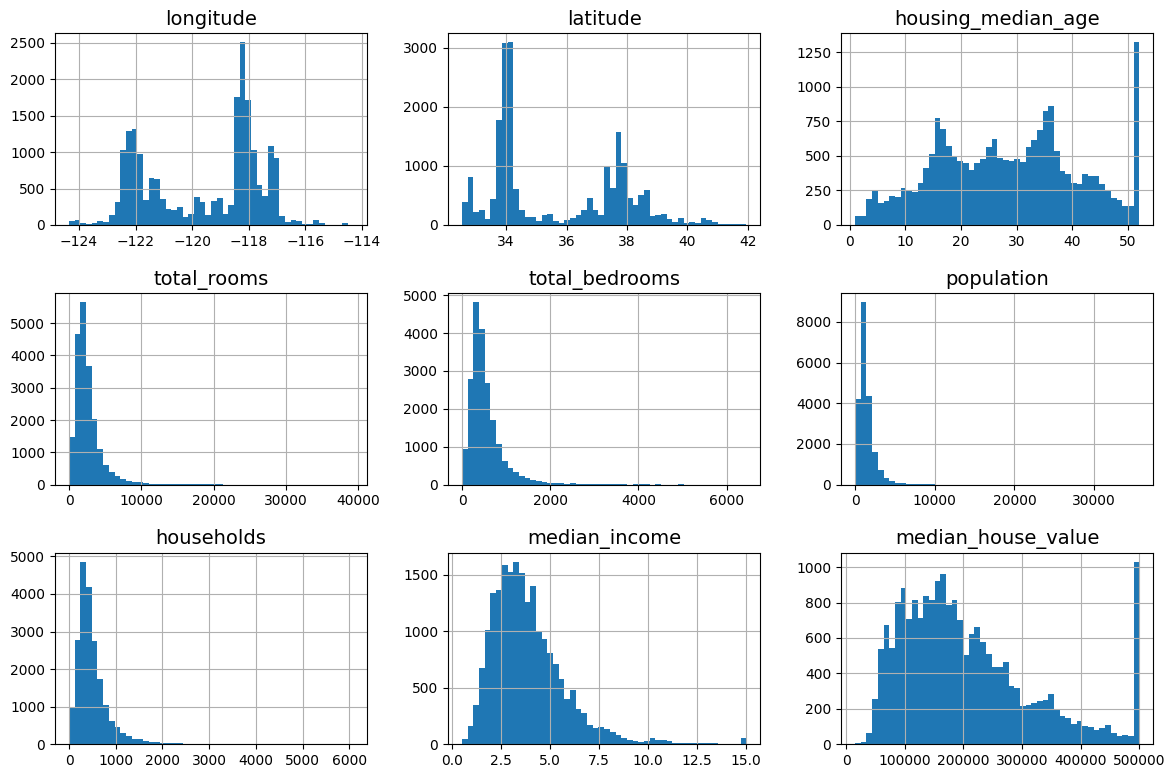

In [7]:
# 각 컬럼의 분포.. 히스토그램으로 데이터 의 분포를 확인
plt.rc('font', size=14)
plt.rc('axes', labelsize=14,titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig('attribute_historgram_plots')
plt.show()

In [8]:
# 테스트 세트 만들기
import numpy as np
def shuffle_and_split_data(data, test_ratio):
  shuffle_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffle_indices[:test_set_size]
  train_indeces = shuffle_indices[test_set_size:]
  return data.iloc[train_indeces], data.iloc[test_indices]

In [9]:
train_set, test_set = shuffle_and_split_data(housing,0.2)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [10]:
# 실행결과를 일정하게 유지 랜덤시드를 설정
np.random.seed(42)

In [11]:
# 무작위성 요소  set의 순서. 파이썬 시작시 랜덤하게 시드가 부여되는 hash()함수기반으로 동작합니다.
# (3.3부터 적용  Dos공격을 막기위해서)  PYTHONHASHSEED 환경변수 값을 0으로 설정
# 파이썬 시작후에 설정은 소용없지만. 코렙에서는 노트북을 실행하면 항상 이 변수가 설정

In [12]:
from zlib import crc32  # hash값을 생성하는 함수
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio*2**32  # 32비트 부동소수점과 비교
# 이 값보다 작으면 데이터가 테스트 집합으로 할당
def split_data_with_id_hash(data,test_ratio,id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]
#   ~in_test_set : in_test_set을 만족하지 않는 데이터

In [13]:
housing_with_id = housing.reset_index()  # index열 추가
train_set, test_set =  split_data_with_id_hash(housing_with_id,0.2,'index')

In [14]:
housing_with_id['id'] = housing['longitude']*1000+housing['latitude']
train_set, test_set =  split_data_with_id_hash(housing_with_id,0.2,'id')

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [16]:
test_set['total_bedrooms'].isnull().sum()

44

In [17]:
# 인구의 여성비율이 51.1%일때 1000명으로 구성된 랜덤 샘플에서 여성이 48.5% 작거나 53.3%보다 많을 확률계산
# 이항분포를 사용   누적분포함수 : cdf() 메서드 --> 여성의 수가 주어진 값보다 작거나 같을 확률반환
from scipy.stats import binom
sample_size = 1000
ratio_female = 0.511
proba_too_small =  binom(sample_size,ratio_female).cdf(485-1)  # 484이하의 값이 나올 확률 계산
proba_too_large = 1- binom(sample_size,ratio_female).cdf(534)
print(proba_too_small + proba_too_large)

0.11534429488259296


In [18]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins=[0.,1.5,3.0,4.5,6.,np.inf],
    labels = [1,2,3,4,5]
)

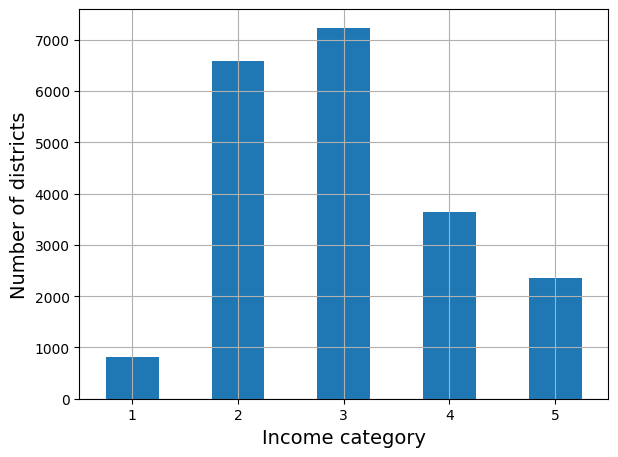

In [19]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel('Income category'); plt.ylabel('Number of districts')
save_fig('housing_income_cat_bar_plot')
plt.show()

In [20]:
# 데이터를 계층적 샘플링하여 훈련 집합과 테스트 집합을 만드는데 사용 클래스
# 클래스 레이블이 불균형할때 유용하게 사용 - 클래스간의 분포를 유지하면서 데이터를 분한
from sklearn.model_selection import StratifiedShuffleSplit

In [21]:
splitter = StratifiedShuffleSplit(n_splits =10, test_size=0.2,random_state=42)
strat_splits = []
for train_index,test_index in splitter.split(housing,housing['income_cat'] ):
  strat_train_set_n =  housing.iloc[train_index]
  strat_test_set_n =  housing.iloc[test_index]
  strat_splits.append([strat_train_set_n,strat_test_set_n])

In [22]:
strat_train_set, strat_test_set =  strat_splits[0]

In [23]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [24]:
# 탐색과 시각화
housing  = strat_train_set.copy()

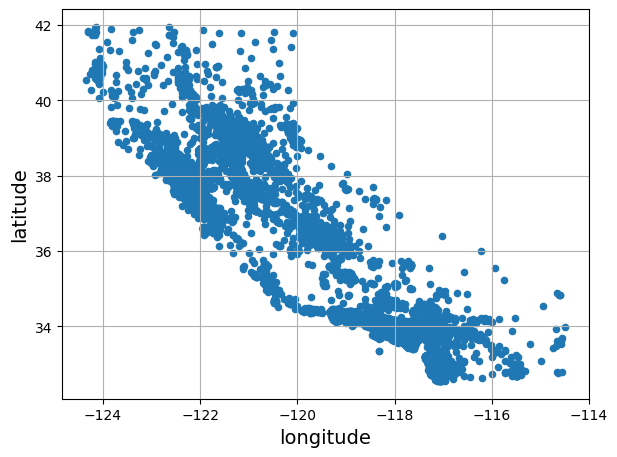

In [25]:
# 지리적 데이터 시각화
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True)
save_fig('bad_visualization_plot')
plt.show()

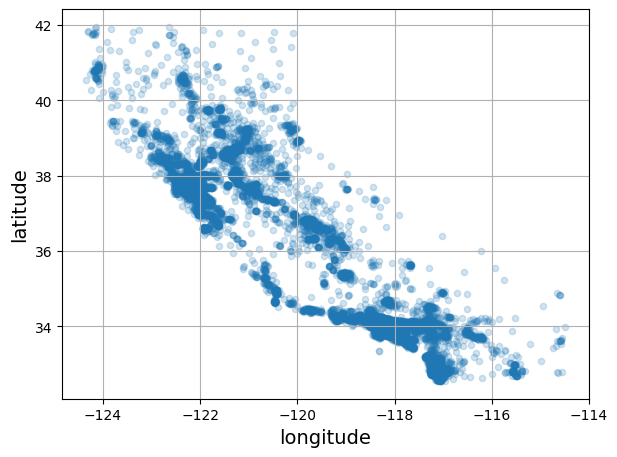

In [26]:
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True, alpha=0.2)
save_fig('better_visualization_plot')
plt.show()

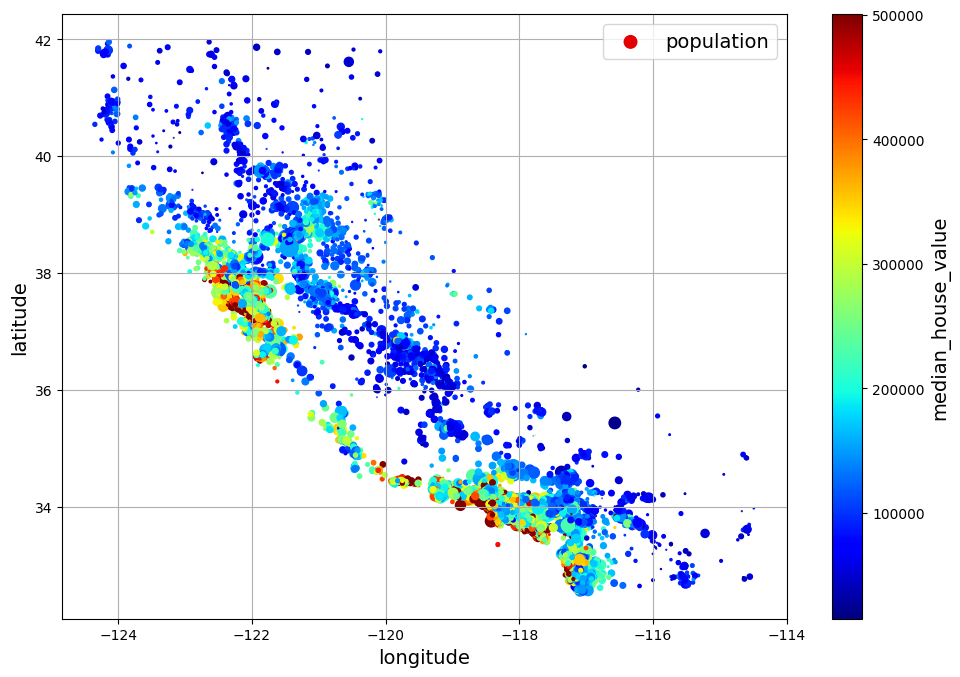

In [27]:
from matplotlib import legend
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True,
             s = housing['population'] / 100, label = 'population',
             c = 'median_house_value', cmap='jet', colorbar = True,
             legend = True,figsize=(10,7),
            #  alpha=0.2
             )
save_fig('housing_prices_scatterplot')
plt.show()

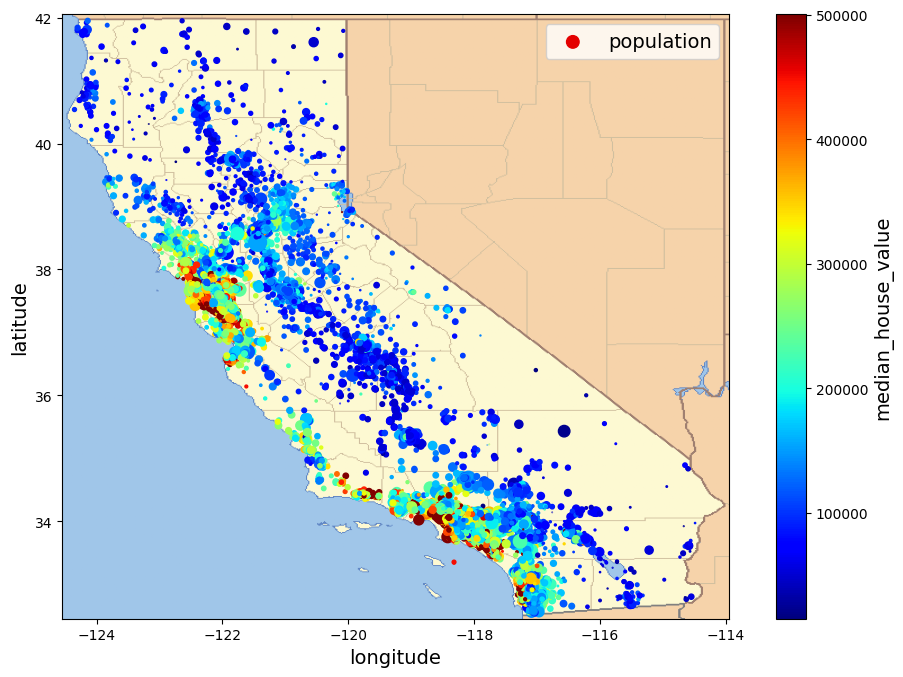

In [28]:
filename = '/content/california.png'
housing.plot(kind='scatter',x='longitude', y='latitude',
            #  grid=True,
             s = housing['population'] / 100, label = 'population',
             c = 'median_house_value', cmap='jet', colorbar = True,
             legend = True,figsize=(10,7),
            #  alpha=0.2
             )
california_img = plt.imread(filename)
axis = -124.55,-113.95,32.45,42.05   #지도에 위도와 경도 범위를 설정  이범위는 캘리포니아 지역
plt.axis(axis)  # 그래프의 축 범위를 제한
plt.imshow(california_img,extent=axis) # extent=axis 이미지의 위치를 조정
save_fig('california_housing_population_prices_plot')
plt.show()


In [29]:
# 상관관계 조사
# pandas 1.5 버전 부터는 수치형 데이터만 포함하는지 여부를 결정하는 numeric_only
corr_matrix = housing.corr(numeric_only=True)

In [30]:
temp = corr_matrix['median_house_value'].sort_values(ascending=False)
print(temp)
temp.index[:4]

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age'],
      dtype='object')

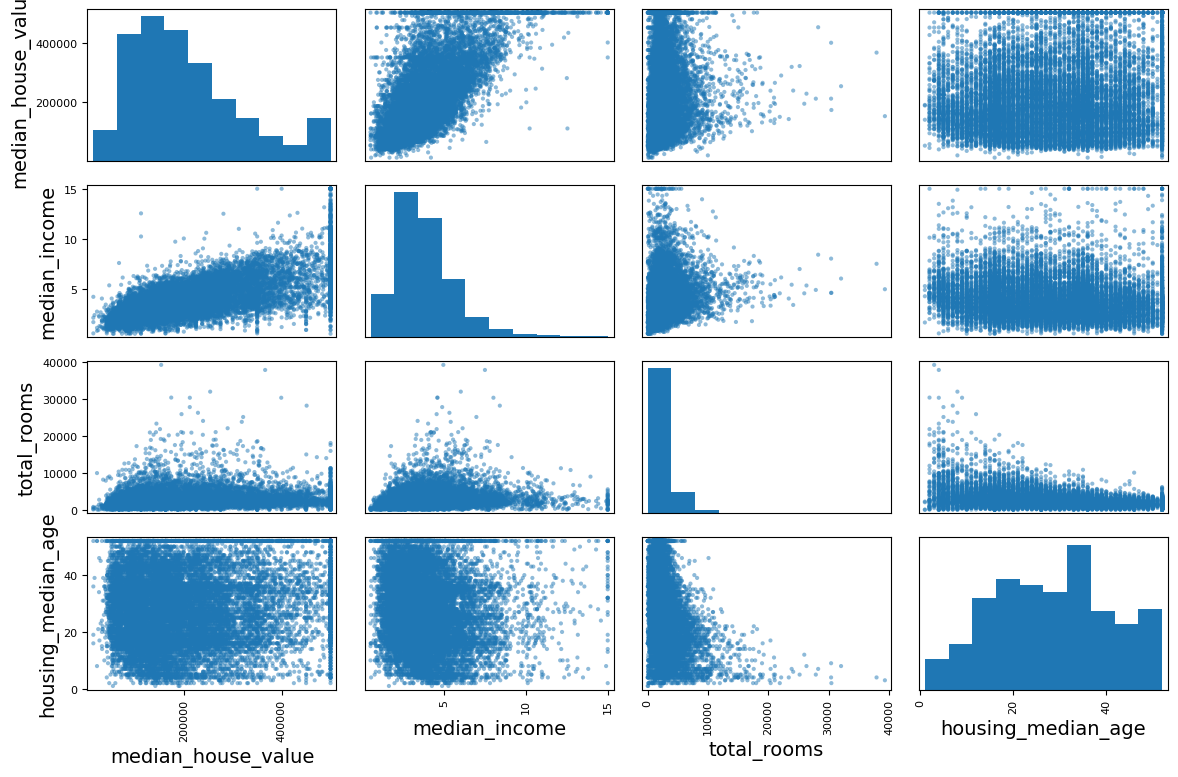

In [31]:
from pandas.plotting import scatter_matrix
attributes = list(temp.index[:4])
scatter_matrix(housing[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")
plt.show()

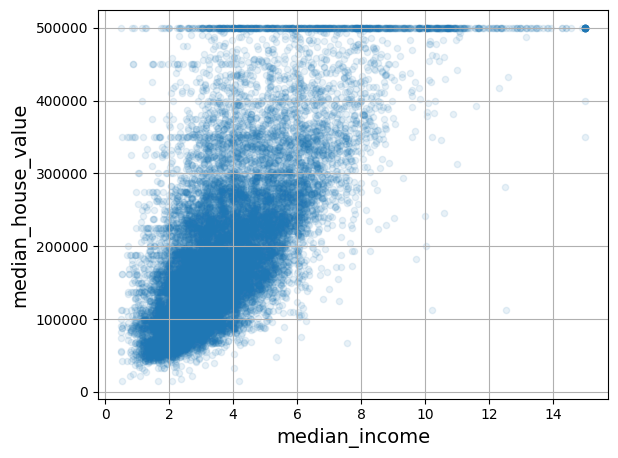

In [32]:
housing.plot(kind='scatter',x='median_income', y='median_house_value',alpha=0.1,grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

In [33]:
# 특성 조합으로 실험
housing['rooms_per_ratio'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population']  / housing['households']

In [34]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16344 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  income_cat          16512 non-null  category
 11  rooms_per_ratio     16512 non-null  float64 
 12  bedrooms_ratio      16344 non-null  float64 
 13  people_per_house    16512 non-null  float64 
dtypes: category(1), float64(12), object(1)
memory usage: 1.8+ MB


In [35]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_ratio       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [36]:
# 머신러닝을 위한 데이터 준비
housing =  strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [37]:
null_rows_idx =  housing.isnull().any(axis=1)  # 결측치가 있는 row를 찾는다.
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND,3
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN,3
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN,3
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN,4
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN,5


In [38]:
housing_option1 = housing.copy()
# housing_option1.dropna('total_bedrooms', axis=1)
# housing_option1.dropna(subset=['total_bedrooms'])

In [39]:
housing_option2 = housing.copy()
median = housing['total_bedrooms'].median()
housing_option2['total_bedrooms'].fillna(median,inplace=True)

In [40]:
# 사이킷런을 이용해서 결측치를 처리
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num =  housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index = housing_num.index)
housing_tr[null_rows_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020
...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,434.0,954.0,397.0,3.7813
366,-122.50,37.75,44.0,1819.0,434.0,1137.0,354.0,3.4919
18241,-121.44,38.54,39.0,2855.0,434.0,1217.0,562.0,3.2404
18493,-116.21,33.75,22.0,894.0,434.0,830.0,202.0,3.0673


In [41]:
# 이상치
from sklearn.ensemble import IsolationForest
isolation_forest =  IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
# 이상치는 -1  정상은 1

In [42]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [43]:
# 이상치를 삭제하고 싶다
# housing =  housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

텍스트와 범주형 데이터 다루기

In [44]:
# 범주형 데이터 ocean_proximity 전처리
housing_cat =  housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [45]:
# 순서형(ordinal) 데이터 / 명목형(nominal) 데이터
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder =  OrdinalEncoder()
housing_cat_encoded =  ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [46]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
df_test = pd.DataFrame({'ocean_proximity':['ISLAND','NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [50]:
cat_encoder.transform(df_test).toarray()

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
df_test_unknown = pd.DataFrame({"ocean_proximity" : ['<1H OCEAN','ISLAND']})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [52]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [53]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [54]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [55]:
cat_encoder.transform(df_test_unknown).toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [56]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index )
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [57]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [58]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

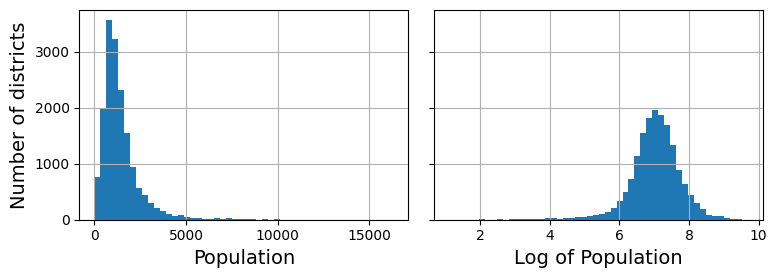

In [59]:
# 로그변환을 하는 이유
# 데이터분포의 왜곡 보정 : 데이터가 치우쳐진경우 왜곡을 줄여준다. 특히 분산이 크거나 꼬리 부분이 긴 경우
# 선형 관계강화 : 몇몇의 경우, 로그변환을 하면 데이터간의 관계를 선형으로 만들어줄수 있다
# 스케일 조정 : 데이터를 적절한 범위로 압축, 모델이 일부 변수에 과도하게 영향을 받는것을 방지

fig,axs =  plt.subplots(1,2,figsize=(8,3), sharey=True)
housing['population'].hist(ax = axs[0],bins=50)
housing['population'].apply(np.log).hist(ax = axs[1],bins=50)  # 데이터 분포가 한쪽으로 치우져져 있거나 꼬리가 긴 경우에 유용
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of Population')
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [60]:
#rbf 커널 라이브러리  : Radial Basis Function(RBF) 커눌을 사용 두 개의 데이터 포인트간의 유사도를 계산
# SVM 머신의 알고리즘에 사용
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 =  rbf_kernel(housing[['housing_median_age']], [[35]], gamma = 0.1)

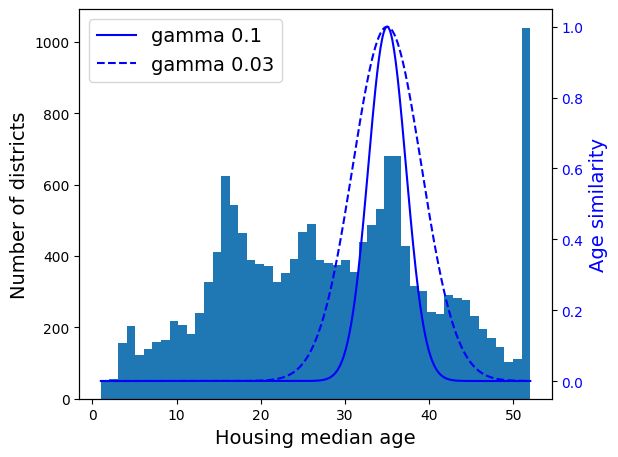

In [61]:
ages =  np.linspace(housing['housing_median_age'].min(), housing['housing_median_age'].max(),500).reshape(-1,1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages,[[35]], gamma = gamma1)
rbf2 = rbf_kernel(ages,[[35]], gamma = gamma2)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Housing median age')
ax1.set_ylabel("Number of districts")
ax1.hist(housing['housing_median_age'], bins=50)

ax2 = ax1.twinx()  # x축을 공유하는 쌍둥이 축을 만듭니다.
color = 'blue'
ax2.plot(ages,rbf1, color = color, label = 'gamma 0.1')
ax2.plot(ages,rbf2, color = color, label = 'gamma 0.03', linestyle='--')
ax2.tick_params(axis='y',labelcolor=color)
ax2.set_ylabel('Age similarity', color=color)

plt.legend()
save_fig('age_similarity_plot')
plt.show()

In [62]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

In [63]:
model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
# 새로운 데이터를 가정- 기존에 가지고 있는데이터 중에서
some_new_data = housing[['median_income']].iloc[:5]

scaled_predictions =  model.predict(some_new_data)
predictions = target_scaler.inverse_transform( scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [64]:
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions =  model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [65]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

In [66]:
from sklearn.base import BaseEstimator,TransformerMixin   # 사이킷런의 슈퍼클래스
from sklearn.utils.validation import check_array, check_is_fitted
#사용자 정의 변환기
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):
    self.with_mean = with_mean
  def fit(self,X, y= None):  # y는 사용하지 않더라고 넣어줘야 한다
    X = check_array(X) # X가 부동소수점 배열인지 확인
    self.mean_  = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1]  # 모든 추정기  fit() 에서 이를 저장한다.
    return self  # 항상 self 를 반환한다
  def transform(self, X):
    check_is_fitted(self) # (훈련으로) 학습된 속성이 있는지 확인합니다.
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X-self.mean_
    return X / self.scale_

In [67]:
from types import new_class
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator,TransformerMixin):
  def __init__(self, n_clusters=10,gamma=1.0,random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state
  def fit(self, X, y=None,sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, n_init=10,random_state=self.random_state)
    self.kmeans_.fit(X,sample_weight=sample_weight)
    return self  # fit 메소드는 항상 self를 반환한다
  def transform(self,X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_,gamma = self.gamma)
  def get_feature_names_out(self,names=None):
    return [ f"클러스터 {i} 유사도" for i in range(self.n_clusters)]

In [68]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
silmilarities = cluster_simil.fit_transform(housing[['latitude','longitude']], sample_weight=housing_labels)

In [69]:
silmilarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

In [70]:
silmilarities[:3].max(axis=1)

array([0.98661549, 0.98954599, 0.70010002])

In [71]:
housing['Max cluster similarity'] = silmilarities.max(axis=1)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,Max cluster similarity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,2,0.986615
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5,0.989546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,2,0.700100
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,2,0.646902
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3,0.894935


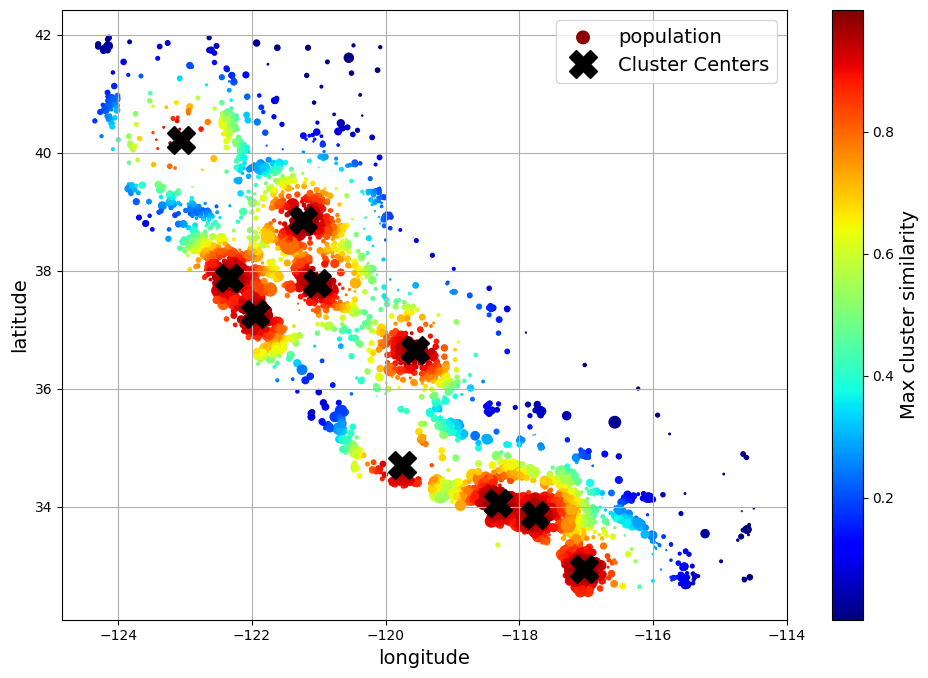

In [72]:
housing.plot(kind='scatter',x = 'longitude', y='latitude',grid = True,
             s=housing['population'] / 100, label = 'population',
             c = 'Max cluster similarity',
             cmap='jet', colorbar = True,
             legend = True,
             figsize=(10,7)
             )
plt.plot(cluster_simil.kmeans_.cluster_centers_[:,1], cluster_simil.kmeans_.cluster_centers_[:,0],
         linestyle='', color='black', marker='X', markersize = 20, label = 'Cluster Centers'
         )
plt.legend()
save_fig('distirct_cluster_plot')
plt.show()

수치 특성을 전처리하는 파이프라인

In [73]:
# 결측치에서 누락된 값을 중앙값으로 대처하고 데이터를 표준화(정규화)
from sklearn.pipeline import Pipeline
num_pipeline =  Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
         ])

In [74]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

In [75]:
from sklearn import set_config
set_config(display='diagram')
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [76]:
housing_num[housing_num.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020


In [77]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [78]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,columns = num_pipeline.get_feature_names_out(), index = housing_num.index
)

In [79]:
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [80]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [81]:
num_pipeline[1]

StandardScaler()

In [82]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [83]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler()}

In [84]:
num_pipeline.named_steps['simpleimputer']

SimpleImputer(strategy='median')

In [85]:
num_pipeline.set_params(simpleimputer__strategy = 'median')

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [86]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   longitude               16512 non-null  float64 
 1   latitude                16512 non-null  float64 
 2   housing_median_age      16512 non-null  float64 
 3   total_rooms             16512 non-null  float64 
 4   total_bedrooms          16344 non-null  float64 
 5   population              16512 non-null  float64 
 6   households              16512 non-null  float64 
 7   median_income           16512 non-null  float64 
 8   ocean_proximity         16512 non-null  object  
 9   income_cat              16512 non-null  category
 10  Max cluster similarity  16512 non-null  float64 
dtypes: category(1), float64(9), object(1)
memory usage: 1.4+ MB


In [87]:
housing.loc[:,:'median_income'].columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [88]:
from sklearn.compose import ColumnTransformer
num_attribs = housing.loc[:,:'median_income'].columns.tolist()
cat_attribs = ['ocean_proximity']
num_attribs, cat_attribs

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income'],
 ['ocean_proximity'])

In [89]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
# 다양한 특성을 처리하는 전체 전처리 파이프라인 구축

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline,cat_attribs)
])

In [90]:
from sklearn.compose import make_column_selector, make_column_transformer
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [91]:
housing_prepared =  preprocessing.fit_transform(housing)

In [92]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns = preprocessing.get_feature_names_out(),
    index = housing.index
)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__Max cluster similarity,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.665581,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.679697,1.0,0.0,0.0,0.0,0.0


In [93]:
from sklearn.preprocessing import FunctionTransformer
def column_ratio(X):  #  데이터가 주어지면 첫번째 열을 두번째열로 나눈 비율을 계산
  return X[:,[0]] / X[:,[1]]
def ratio_name(function_tansformer, feature_names_in):
  return ['ratio']   # get_feature_names_out 에서 사용
def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy='median'),
      FunctionTransformer(column_ratio,feature_names_out =ratio_name ),
      StandardScaler()
  )
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

In [94]:
preprocessing = ColumnTransformer([
    ('bedrooms',ratio_pipeline(),['total_bedrooms','total_rooms']),
    ('rooms_per_house', ratio_pipeline(),['total_rooms','households']),
    ('people_per_house',ratio_pipeline(), ['population','households']),
    ('log',log_pipeline,['total_bedrooms','total_rooms','population','households','median_income']),
    ('geo',cluster_simil,['latitude','longitude']),
    ('cat',cat_pipeline,make_column_selector(dtype_include=object))
    ],
    remainder = default_num_pipeline)  # 남은 특성은 housing_median_age

In [95]:
housing_prepared =  preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 26)

In [96]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age',
       'remainder__income_cat', 'remainder__Max cluster similarity'],
      dtype=object)

In [97]:
# 데이터 전처리
# 결측치를 처리
# 데이터 표준화
# 각 컬럼별 특성에 맞게 처리... pipeline 을 이용해서


모델 선택과 훈련

훈련세트를정해서 훈련하고 평가

In [98]:
from sklearn.linear_model import LinearRegression

In [99]:
lin_reg = make_pipeline(preprocessing,LinearRegression())
lin_reg.fit(housing,housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e5...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e518e3f1b40>)])),
                ('linearregression', LinearRegression())])

In [100]:
housing_predictions =  lin_reg.predict(housing)
housing_predictions[:5].round(-2) # 십의 자리에서 반올림

array([257900., 399300., 101500.,  76400., 312200.])

In [101]:
# 정답과 비교
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [102]:
# 오차 비율
error_ratios =  housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
','.join([f"{100*ratio:.1f}%" for ratio in error_ratios])

'-43.7%,-17.5%,-0.2%,-20.5%,-13.7%'

In [103]:
from sklearn.metrics import mean_squared_error
mean_squared_error(housing_labels,housing_predictions,squared=False)  # squared=False  RMSE 가 된다

66775.70987149018

In [104]:
np.sqrt(mean_squared_error(housing_labels,housing_predictions ) )

66775.70987149018

In [105]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing,DecisionTreeRegressor())
tree_reg.fit(housing,housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e5...
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e518e3f1b40>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [106]:
housing_predictions =  tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels,housing_predictions,squared=False)
tree_rmse

0.0

In [107]:
housing_predictions[:5],housing_labels[:5]

(array([458300., 483800., 101700.,  96100., 361800.]),
 13096    458300.0
 14973    483800.0
 3785     101700.0
 14689     96100.0
 20507    361800.0
 Name: median_house_value, dtype: float64)

교차검증을 통한 평가

In [108]:
# 보통 회귀에서는 RMSE를 사용 , cross_val_score 스코어링 메트릭.. 클수록 좋은 지료를 사용하는 것이 관례
# RMSE는 값이 작을수록 모델의 성능이 더 좋다는 관점에서 보면 클수록 좋은 지표
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg,housing,housing_labels,scoring = 'neg_root_mean_squared_error', cv=10)

In [109]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65917.942983
std       2280.037580
min      62234.666692
25%      64139.308464
50%      66588.464282
75%      67783.105788
max      68562.958183
dtype: float64

In [110]:
# 선형 모델의 점수를 계산
lin_rmses = -cross_val_score(lin_reg,housing,housing_labels,scoring = 'neg_root_mean_squared_error', cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     67855.322400
std       3379.174990
min      63866.554164
25%      66535.542023
50%      66957.282235
75%      68084.392503
max      76532.715813
dtype: float64

In [111]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing,RandomForestRegressor())
forest_rmses = -cross_val_score(forest_reg,housing,housing_labels,scoring = 'neg_root_mean_squared_error', cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46786.260590
std       1031.946702
min      45102.665852
25%      46141.486394
50%      46818.524138
75%      47116.629340
max      48826.594591
dtype: float64

In [120]:
# 교차검증 수치값과 전체데이터를 훈련세트로 가정해서 두 수치를 비교
forest_reg.fit(housing, housing_labels)
housing_predictions =  forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,squared=False)
forest_rmse

17517.24644938734

미세튜닝
  - 그리드 탐색

In [132]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])
param_grid = [
    {'preprocessing__geo__n_clusters' : [5,8,10],
    'random_forest__max_features':[4,6,8]},
    {'preprocessing__geo__n_clusters' : [10,15],
    'random_forest__max_features':[6,8,10]}
]
grid_search =  GridSearchCV(full_pipeline,param_grid=param_grid,cv=3,scoring='neg_root_mean_squared_error')
grid_search.fit(housing,housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7e518e3f1b40>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [138]:
# 하이퍼파라메터 리스트
str(full_pipeline.get_params().keys())[:1000] + '...'

"dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose

In [139]:
# 최상의 파라메터 조합
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [140]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e518eb...
                                                                    n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e518ec39e70>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [152]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score',ascending=False, inplace=True)
cv_res = cv_res.rename(columns={
    'param_preprocessing__geo__n_clusters' : 'n_clusters',
    'param_random_forest__max_features' : 'max_features',
    'split0_test_score':'split0',
    'split1_test_score' : 'split1',
    'split2_test_score':'split2',
    'mean_test_score':'mean_test_rmse'
})
cv_res = cv_res[['n_clusters','max_features','split0','split1','split2','mean_test_rmse']]
cv_res[['split0','split1','split2','mean_test_rmse']]  = -cv_res[['split0','split1','split2','mean_test_rmse']].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,44112,44163,45054,44443
13,15,8,44315,44577,45525,44806
14,15,10,44944,44967,46061,45324
7,10,6,45251,45390,46253,45632
9,10,6,45251,45390,46253,45632


랜덤탐색

In [153]:
# RandomizedSearchCV 를 개선한 시험버전이 있음
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [154]:
from scipy.stats import randint

In [ ]:
param_distribs = {
    'preprocessing__geo__n_clusters':randint(low=3,high=50),
    'random_forest__max_features':randint(low=2, high=20)
}
rnd_search = HalvingRandomSearchCV(
    full_pipeline,param_distributions = param_distribs, cv=5,scoring = 'neg_root_mean_squared_error',random_state=42
)
rnd_search.fit(housing,housing_labels)

In [160]:
randint.rvs(low=3,high=50,size=5)

array([19, 49, 25, 17, 39])

In [123]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat', 'Max cluster similarity'],
      dtype='object')

지도 시각화

In [112]:
# !pip install folium

In [113]:
# import folium

In [114]:
# # 35.23678400,139.11684800
# m = folium.Map(location=['37.5','127'],
#               #  tiles="cartodb positron",
#                zoom_start=12,
#                width=750,
#                height=500
#               )

In [115]:
# folium.Marker(
#     location=['37.5','127'],
#     tooltip="Click me!",
#     popup="서초구",
#     icon=folium.Icon(icon="cloud"),
# ).add_to(m)

In [116]:
# 주소를 위경로 변환

In [117]:
# curl -v -X GET "https://dapi.kakao.com/v2/local/search/address.json" \
#   -H "Authorization: KakaoAK ${REST_API_KEY}" \
#   --data-urlencode "query=전북 삼성동 100"

In [118]:
# import requests
# # Rest API는  requests.get()을 이용해서  url주소 요청하면.. 서버에서 response응답 객체를 받는다
# REST_API_KEY = "92adac142332ceaba7167c6c0d20262d"
# base_url = "https://dapi.kakao.com/v2/local/search/address.json";
# headers = {"Authorization" : f"KakaoAK {REST_API_KEY}"}
# params = {"query":"서울시 용산구 소월로 323"}
# response =  requests.get(base_url, headers=headers,params=params)
# if response.status_code == 200:
#   data = response.json()
#   x,y = data['documents'][0]['x'], data['documents'][0]['y']

In [119]:
# m = folium.Map(location=['37.5','127'],
#               #  tiles="cartodb positron",
#                zoom_start=12,
#                width=750,
#                height=500
#               )

# folium.Marker(
#     location=['37.5415755386499','126.996940925194'],
#     tooltip="서울시 용산구 소월로 323",
#     popup="",
#     icon=folium.Icon(icon="cloud"),
# ).add_to(m)